### The Case for Climate on Reddit
#### Analyzing communities and sentiment

#### Descriptive analysis
1) Volumes

2) Relation graphs

3) Polarity/Subjectivity

In [2]:
import praw
import time
import cPickle
import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as net
from scipy.stats import ttest_ind
from datetime import datetime
from pattern.en import lemma, polarity

For version info: <a href=#version>version</a>

In [2]:
subs = ['climate','climateskeptics']

In [3]:
#Pickler functions
def savepickle(data, name, path):
    with open(path+'{}.pkl'.format(name), 'w') as f:
        cPickle.dump(data, f)
def loadpickle(name, path):
    with open(path+'{}.pkl'.format(name), 'r') as f:
        data = cPickle.load(f)
    return(data)

### Data pulling: Only run if you want to pull new data
Uncomment and insert API crendentials, then you can use the "getsubs" function to pull all submissions information and save to the data folder.

In [87]:
#Reddit API credentials
#client_id = ''
#secret = ''
#user_agent = ''

In [88]:
#reddit = praw.Reddit(client_id=client_id,
#                     client_secret=secret,
#                     user_agent=user_agent)

In [130]:
def getsubs(reddit, since, until, sub):
    #Convert to epoch timestamp
    since_ts = time.mktime(datetime.date(datetime.strptime(since, "%Y-%m-%d")).timetuple())
    until_ts = time.mktime(datetime.date(datetime.strptime(until, "%Y-%m-%d")).timetuple())
    limit = 25
    #Submission objects within timeframe
    target_subs = []
    #For pagination, will store latest result 
    page_params = {}
    subreddit = reddit.subreddit(sub)
    latest = until    
    
    #Iterate until hit limit (i.e. the last submission == the latest from the previous iteration)
    while True:
        for s in subreddit.new(limit=limit, params=page_params):
            if (s.created_utc>=since_ts)&(s.created_utc<until_ts):
                target_subs.append(s)
        page_params = {'after':s.fullname}
        if latest == s.created_utc:
            break
        else:
            latest = s.created_utc
    print "Obtained {} submissions for subreddit {}".format(len(target_subs), sub)
    return(target_subs)

In [3]:
##get sub data, pickle
#for s in subs:
#    target_subs = getsubs(reddit, '2016-11-1', '2016-12-1', s)
#    savepickle(target_subs, s, './data/')

### Data parsing: Can be run on data in /data folder
- Parses submissions using the __dict__ special attribute, inserts into pandas DataFrame
- Parses comments attached to each submission, inserts into DataFrame
    - Will iterate through replies to each comment, including those hidden behind MoreComments object.

In [4]:
#Make submission/comment df
#Can be made recursive function in a production version
subDF = pd.DataFrame()
comDF = pd.DataFrame()
for s in subs:
    target_subs = loadpickle(s, './data/')
    #For each submission, parse and add to DF
    for t in target_subs:
        sub = pd.Series(t.__dict__)[['domain', 'created','subreddit', 'title', 'url',
                                     'name', 'author', 'num_comments', 
                                     'score']]
        subDF = subDF.append(sub, ignore_index=True)
        #For each comment, iterate through replies, add to comment DF
        #Submission id = fullname of submission
        #Parent id = parent comment, or = submission if first in thread
        for c in t.comments:
            commentset = set()
            if c.id not in commentset:
                comment = pd.Series(c.__dict__)[['parent_id', 'id', 'body', 'created', 
                                             'score','author']]
                comment['submission_id'] = t.fullname
                comment['subreddit'] = c.subreddit
                comDF = comDF.append(comment, ignore_index=True)
                commentset.add(c.id)
            for r in c.__dict__['_replies']:
                #Check if it's a morecomments object (needs to be expanded)
                if not hasattr(r, 'body'):
                    for mr in r.comments():
                        if mr.id not in commentset:
                            reply = pd.Series(mr.__dict__)[['parent_id', 'id', 'body', 'created', 
                                             'score','author']]
                            reply['parent_id'] = c.id
                            reply['submission_id'] = t.fullname
                            reply['subreddit'] = c.subreddit
                            comDF= comDF.append(reply, ignore_index=True)
                            commentset.add(mr.id)
                if r.id not in commentset:
                    reply = pd.Series(r.__dict__)[['parent_id', 'id', 'body', 'created', 
                                             'score','author']]
                    reply['parent_id'] = c.id
                    reply['submission_id'] = t.fullname
                    reply['subreddit'] = c.subreddit
                    comDF= comDF.append(reply, ignore_index=True)
                    commentset.add(r.id)

In [5]:
#Create colors to be used for subreddits
colors = {'climateskeptics':'red', 'climate':'blue', 'both': 'purple'}

In [6]:
#Used UTC timestamps, so there's some submissions/comments in 12/1/16, will need to trim those
dec1 = time.mktime(datetime.date(datetime.strptime('2016-12-1', "%Y-%m-%d")).timetuple())
subDF = subDF[subDF.created < dec1]
comDF = comDF[comDF.created < dec1]

In [7]:
#Add timestamp-date conversion
#Doing this for simplicity of visuals
subDF['date'] = pd.to_datetime(subDF.created.apply(lambda x: datetime.fromtimestamp(x).date()))
comDF['date'] = pd.to_datetime(comDF.created.apply(lambda x: datetime.fromtimestamp(x).date()))

In [8]:
for df in [subDF, comDF]:
    #Get display name for users
    df['author_name'] = df[df.author.notnull()].author.apply(lambda x: x.name)
    #Get display name for subreddits
    df['sub_name'] = df.subreddit.apply(lambda x: x.display_name)

### Activity volumes 

In [9]:
#volume graph
def volplot(dates, sub, normalize=None):
    if normalize is not None:
        p = (dates.value_counts()/normalize).plot(rot=90, label=sub, color = colors[sub], alpha = .7)
    else:
        p = dates.value_counts().plot(rot=90, label=sub, color = colors[sub], alpha = .7)
    p.set_axis_bgcolor('white')
    p.tick_params(axis=u'both', which=u'both',length=0)
    return(p)

#Get top count
def topmost(data):
    tops = data['created'].count()
    tops.sort_values(ascending=False, inplace=True)
    return(tops)

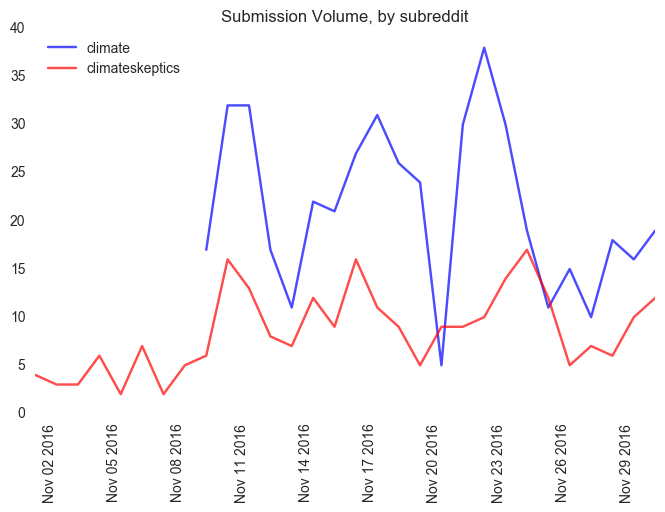

In [10]:
subs = ['climate', 'climateskeptics']
#Plot submission volumes
for s in subs:
    volplot(subDF[subDF.subreddit==s].date, s)
legend = plt.legend(loc='upper left', frameon=False)
plt.title('Submission Volume, by subreddit')
plt.show()

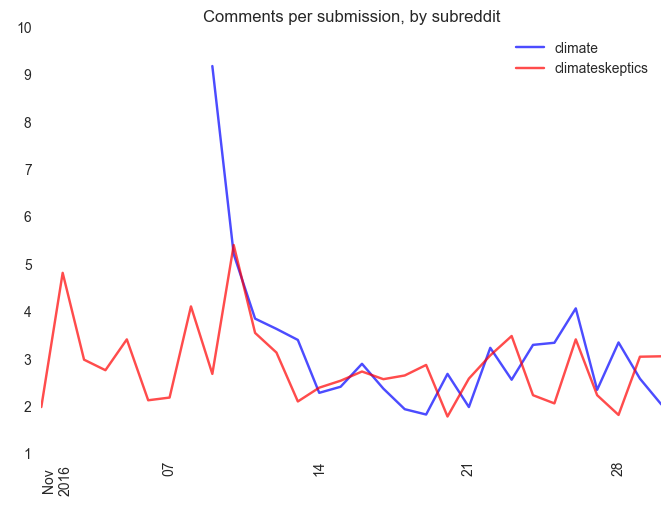

In [11]:
#Plot comment volumes
for s in subs:
    #Normalize by number of posts per date
    normalize = comDF[comDF.subreddit==s].groupby('date')['submission_id'].apply(lambda x: len(x.unique()))
    volplot(comDF[comDF.subreddit==s].date, s, normalize=normalize)
legend = plt.legend(loc='upper right', frameon=False)
plt.title('Comments per submission, by subreddit')
plt.show()

In [12]:
#Top submissions
topSubs = topmost(subDF.groupby(['date','sub_name']))
#Top comments
topCom = topmost(comDF.groupby(['date','sub_name']))
#Top activity (total)
topAct = topSubs.add(topCom, fill_value=0).sort_values(ascending=False)
topAct = topAct.reset_index()

#Most posting activity (comments + submissions)
for s in subs:
    print "Top active days {}: \n {}".format(s, 
                                            topAct[topAct.sub_name==s].head())

Top active days climate: 
         date sub_name  created
0 2016-11-11  climate      148
1 2016-11-10  climate      147
3 2016-11-09  climate      109
4 2016-11-23  climate       97
6 2016-11-16  climate       94
Top active days climateskeptics: 
          date         sub_name  created
2  2016-11-10  climateskeptics      119
5  2016-11-11  climateskeptics       95
11 2016-11-12  climateskeptics       71
12 2016-11-23  climateskeptics       70
15 2016-11-14  climateskeptics       65


### Active Users

In [14]:
#Top users for submissions
topuserSubs = topmost(subDF.groupby(['author_name','sub_name']))
#Top users for comments
topuserCom = topmost(comDF.groupby(['author_name','sub_name']))
#Top users for activity (total)
topuserAct = topuserSubs.add(topuserCom, fill_value=0).sort_values(ascending=False)

for s in subs:
    print "Top submitters {}: \n {}".format(s, 
                                            topuserSubs.reset_index()[topuserSubs.reset_index().sub_name==s].head())
    print "Top commenter {}: \n {}".format(s, 
                                            topuserCom.reset_index()[topuserCom.reset_index().sub_name==s].head())
    print "Top activity {}: \n {}".format(s, 
                                            topuserAct.reset_index()[topuserAct.reset_index().sub_name==s].head())


Top submitters climate: 
            author_name sub_name  created
1              pnewell  climate       80
2           ClimateBot  climate       51
3                xrm67  climate       18
4     avogadros_number  climate       18
6  GlobalClimateChange  climate       14
Top commenter climate: 
      author_name sub_name  created
3    extinction6  climate       46
5       Archimid  climate       34
8       autotldr  climate       29
11  VictorVenema  climate       21
15      rrohbeck  climate       19
Top activity climate: 
     author_name sub_name  created
1       pnewell  climate     81.0
3    ClimateBot  climate     51.0
5   extinction6  climate     46.0
9      Archimid  climate     35.0
13     autotldr  climate     29.0
Top submitters climateskeptics: 
            author_name         sub_name  created
0   logicalprogressive  climateskeptics       83
5              defyccc  climateskeptics       15
9             pr-mth-s  climateskeptics       10
10          Tunderbar1  climateskep

In [15]:
#Create an activity dictionary
#This is for pruning the network graph
actDict = topuserAct.to_dict()
#Subreddit userlist: Three categories, climate, climateskeptic, both
userDict = topuserAct.reset_index().groupby('sub_name')['author_name'].unique().to_dict()
userDict['both'] = set(x for x in userDict['climate'] if x in userDict['climateskeptics'])
userDict['climateskeptics'] = set(userDict['climateskeptics']) - set(userDict['both'])
userDict['climate'] = set(userDict['climate']) - set(userDict['both'])
#Get median activity, by subreddit, for pruning
medAct = topuserAct.reset_index().groupby('sub_name')['created'].median().to_dict()

In [16]:
#Number of unique users
for s in userDict:
    print s, len(userDict[s])

climateskeptics 236
both 12
climate 574


### Network Analysis

In [17]:
#Create edge list
#Submissions: posters and respondents, weight = poster activity
subEdges = subDF[['name','author_name']].merge(comDF[['submission_id','author_name']], left_on='name', right_on='submission_id')
#Drop if it's a comment on their own post (not informative)
subEdges = subEdges[subEdges.author_name_x != subEdges.author_name_y]
#Comments: Commenters and respondents, weight = commenter activity
comEdges = comDF[['id','author_name']].merge(comDF[['parent_id','author_name']], left_on='id', right_on='parent_id')
#Drop if comment on self
comEdges = comEdges[comEdges.author_name_x != comEdges.author_name_y]

In [18]:
#Creat all edge data
allEdges = pd.concat([subEdges[['author_name_x', 'author_name_y']],
                      comEdges[['author_name_x', 'author_name_y']]])
#Drop any missing users
allEdges = allEdges.dropna()

In [19]:
#Trimming functions
def trim_deg(g, degree={'climate':1, 'climateskeptics':1}):
    g2 = g.copy()
    d = net.degree(g2)
    for n in g2.nodes():
        if n == SEED: continue # don't prune the SEED node
        #Check degree conditions for each subreddit
        remove = []
        for s in subs:
            if (n,s) in actDict:
                if d[n] <= degree[s]:
                    remove.append(1)
                else:
                    remove.append(0)
        #If they're below degree thresh for all subreddits they contribute to      
        if 0 not in remove:
            g2.remove_node(n)
    return g2

def trim_edge(g, weight = {'climate':1, 'climateskeptics':1}):
    g2 = net.DiGraph()
    for f, to in g.edges_iter():
        if f == SEED or to == SEED: # keep edges that link to the SEED node
            g2.add_edge(f, to)
        else:
            remove = []
            for s in subs:
                if (f,s) in actDict:
                    if actDict[(f,s)] < weight[s]:
                        remove.append(1)
                    else:
                        remove.append(0)
        if 0 in remove:
            g2.add_edge(f, to)
    return g2

In [20]:
#Create network graph
o = net.DiGraph()
SEED = 'ClimateBot'
for u1, u2 in allEdges.values:
    o.add_edge(u1, u2)
g = net.DiGraph(net.ego_graph(o, SEED, radius=4))
print "Originally, {}".format(len(g))
core = trim_deg(g, degree = {'climate':2, 'climateskeptics':2})
print "After trimming nodes: {}".format(len(core))
#use median activity as weight
core = trim_edge(core, weight = medAct)
print "After trimming edges: {}".format(len(core))
pos = net.spring_layout(core)


Originally, 499
After trimming nodes: 234
After trimming edges: 234


In [21]:
#Get type from userDict
nodeDict = {}
for s in userDict:
    nodeDict[s] = [n for n in core.nodes_iter() if n in userDict[s]]

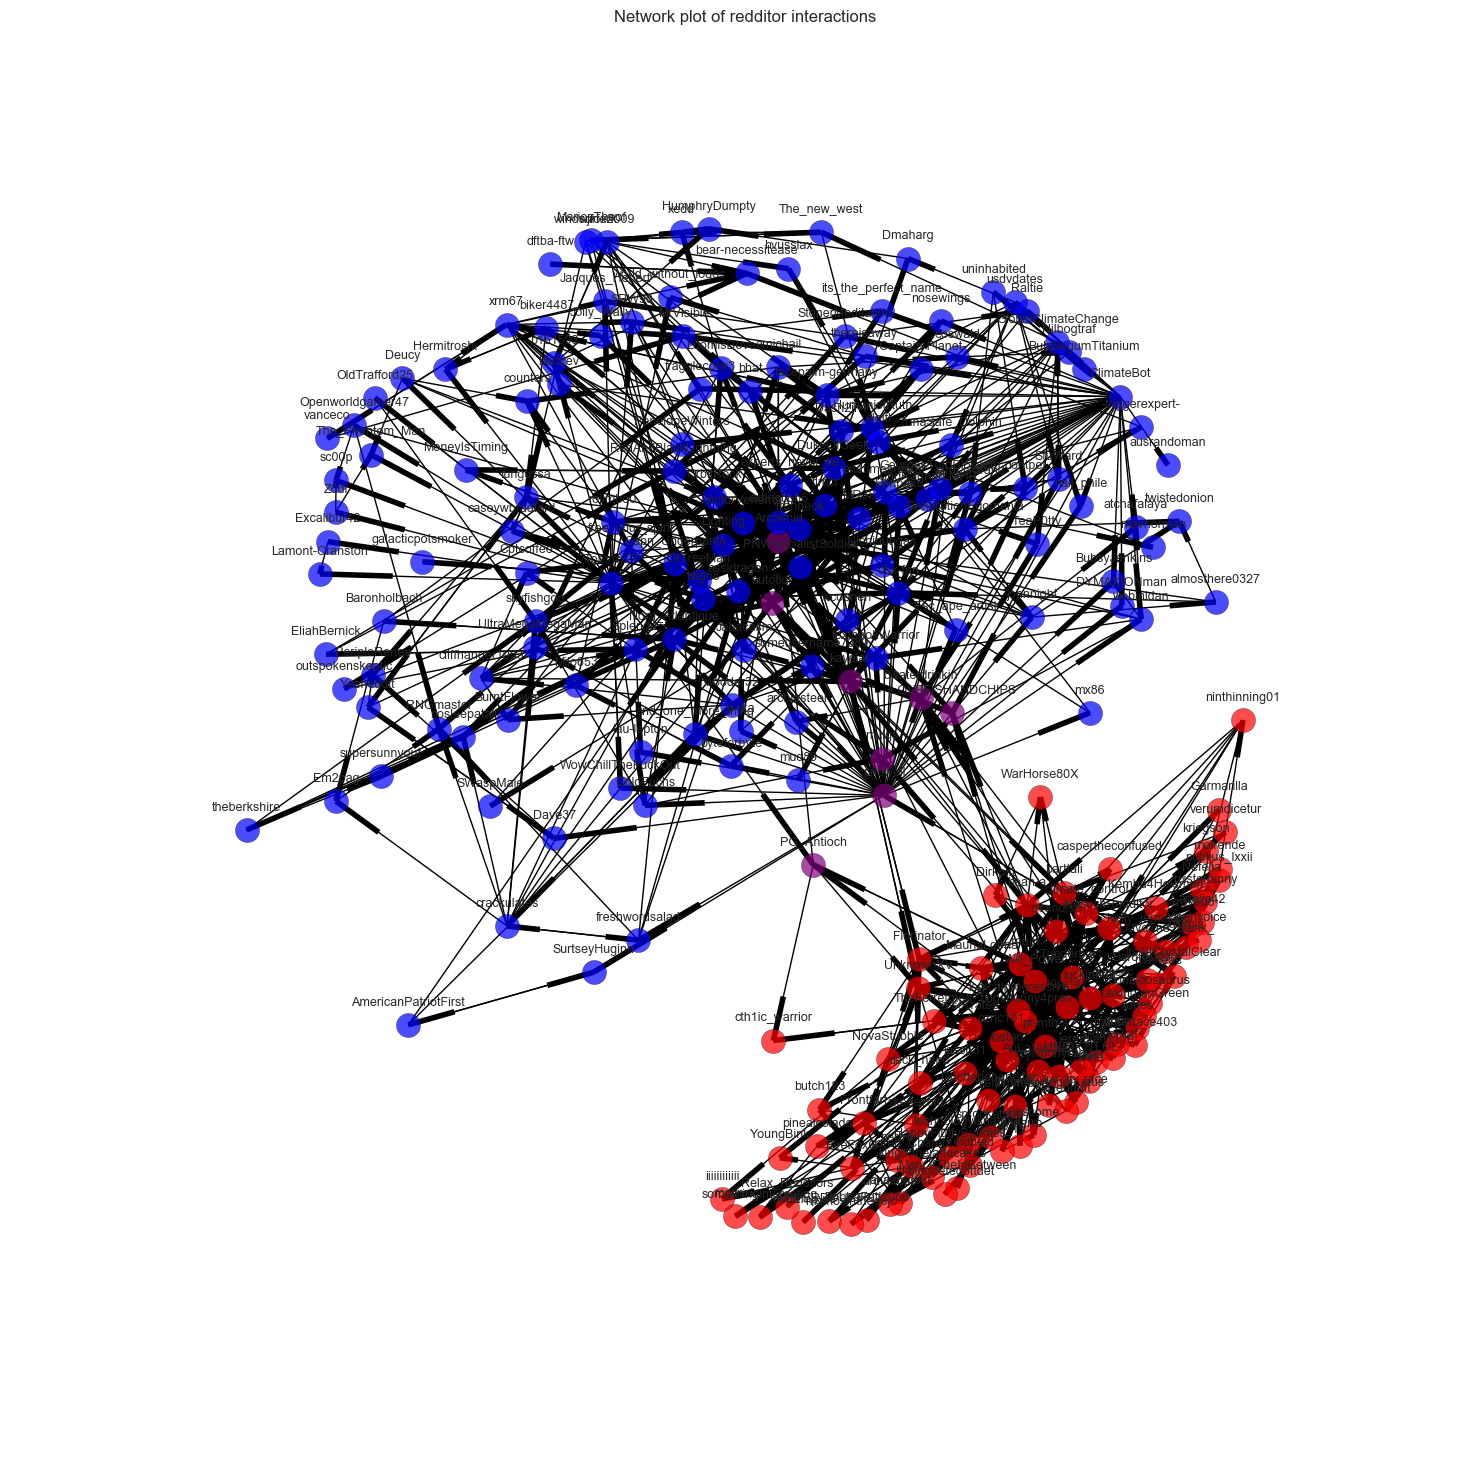

In [22]:
#Plot graph
plt.figure(figsize=(18,18))
plt.axis('off')
#net.draw_networkx_nodes(core, pos)
for s in nodeDict:
    ns = []
    net.draw_networkx_nodes(core, pos, nodelist=nodeDict[s], 
                            node_color = colors[s], 
                            alpha=.7)
net.draw_networkx_edges(core, pos)
for n in core.nodes_iter():
    x, y = pos[n]
    plt.text(x, y+0.02, s=n, horizontalalignment='center', fontsize=9)
plt.title('Network plot of redditor interactions')
plt.show()

### Polarity analysis

In [23]:
#Polarity analysis
#Fx for clean text of commments
def cleantext(txt):
    txt = unicode(txt.lower())
    txt = re.sub('[^\w\s]', '', txt)
    txt = stopwords.clean(txt.split(), "en")
    txt = [lemma(w) for w in txt]
    return(txt)

In [24]:
#Clean text
comDF['body_clean'] = comDF.body.apply(lambda x: cleantext(x))

In [25]:
#Polarity scoring
comDF['polarity'] = comDF.body_clean.apply(lambda x: polarity(x))

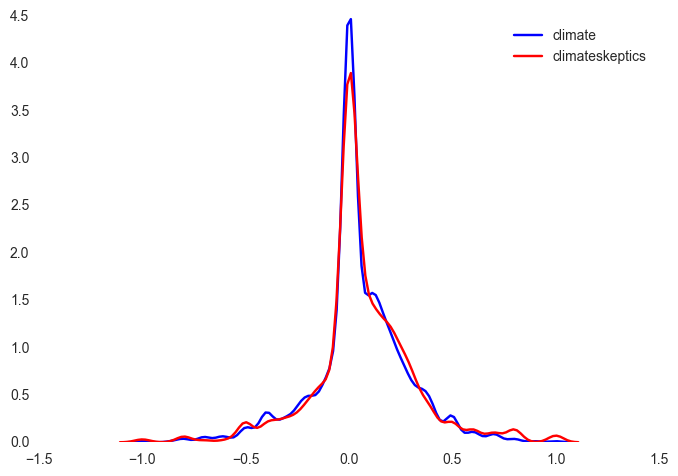

In [26]:
for s in subs:
    p = sns.kdeplot(comDF[comDF.subreddit==s]['polarity'], label=s, color=colors[s])
    p.set_axis_bgcolor('white')
plt.show()

In [27]:
print "Test of differences in polarity"
print ttest_ind(*[comDF[comDF.subreddit==s].polarity for s in subs])
print "Test of differences in score"
print ttest_ind(*[comDF[comDF.subreddit==s].score for s in subs])

Test of differences in polarity
Ttest_indResult(statistic=-1.6644478232207613, pvalue=0.096161898964229206)
Test of differences in score
Ttest_indResult(statistic=0.5572434455690628, pvalue=0.5774164145558085)


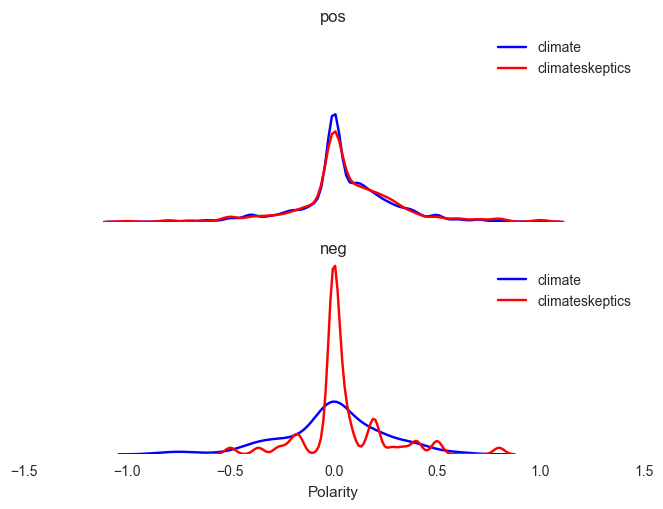

In [28]:
#Polarity distribution, for positive-voted and negative-voted
comDF['pos'] = comDF.score>0.0
comDF['neg'] = comDF.score<=0.0
fig,axs = plt.subplots(2,1, sharey=True, sharex=True)
i = 0
for v in ['pos', 'neg']:
    for s in subs:
        sns.kdeplot(comDF[(comDF.subreddit==s)&(comDF[v]==True)]['polarity'], 
                    label=s, color=colors[s], ax=axs[i])
        axs[i].set_axis_bgcolor('white')
        axs[i].set_yticklabels('')
        axs[i].set_ylabel('')
        axs[i].set_title(v)
    i+=1
axs[-1].set_xlabel('Polarity')
plt.legend()
plt.show()

### Version info <a name='version' />

In [13]:
%version_information praw, time, cPickle, stopwords, re, seaborn, matplotlib, pandas, networkx, scipy, pattern

Software,Version
Python,2.7.12 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]
IPython,5.1.0
OS,Darwin 15.2.0 x86_64 i386 64bit
praw,4.1.0
time,The 'time' distribution was not found and is required by the application
cPickle,1.71
stopwords,0.1.2
re,2.2.1
seaborn,0.7.1
matplotlib,1.5.3
